In [1452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

In [1453]:
#from census import Census
#from us import states
#import censusdata

#c = Census("181f11c579e665cf03575f5cc8313e0d612020b8", year=2019)

In [1454]:
starbuck_df = pd.read_csv('starbucks_directory.csv')
acs_df = pd.read_csv('acs_df.csv')
county_df = pd.read_csv('uszips.csv')

In [1455]:
# Filter for only US locations
starbuck_df = starbuck_df[starbuck_df.Country == 'US']

# Change column name 'State/Province'
starbuck_df.columns.values[6] = 'State'

# Make Postcode 4-5 digits
starbuck_df['Postcode'] = np.where(
    starbuck_df.Postcode.str.len() > 5, starbuck_df.Postcode.str[:-4], starbuck_df.Postcode)

# Display stores w/o zip
starbuck_df[starbuck_df['Postcode'].isnull()] #Address 4546 Boardman Canfield Road, Canfield, OH 44406

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
21549,Starbucks,28180-250430,Canfield,Company Owned,4546 Boardman Canfield Road,Canfield,OH,US,NaN,NaN,GMT-05:00 America/New_York,-80.74,41.03


In [1456]:
# Replace null value for zip
starbuck_df.loc[21549, 'Postcode'] = 44406

# Change Postcode datatype to int
starbuck_df['Postcode'] = starbuck_df['Postcode'].astype(int)

In [1457]:
import geopandas as gpd
from geopandas import GeoDataFrame as gdf
from shapely.geometry import Point, Polygon

In [1458]:
location = starbuck_df[['Latitude', 'Longitude']]
location.head() 

,Latitude,Longitude
11964,61.21,-149.78
11965,61.14,-149.84
11966,61.11,-149.85
11967,61.13,-149.89
11968,61.14,-149.86


In [1459]:
crs = {'init': 'epsg:4326'}

geometry = [Point(xy) for xy in zip(location["Longitude"], location["Latitude"])]
geometry[:3]

geo_df = gpd.GeoDataFrame(location, crs = crs, geometry = geometry)
geo_df.head()

/Users/puri/opt/anaconda3/envs/ML7331/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Latitude,Longitude,geometry
11964,61.21,-149.78,POINT (-149.78000 61.21000)
11965,61.14,-149.84,POINT (-149.84000 61.14000)
11966,61.11,-149.85,POINT (-149.85000 61.11000)
11967,61.13,-149.89,POINT (-149.89000 61.13000)
11968,61.14,-149.86,POINT (-149.86000 61.14000)


In [1460]:
geo_usa = gpd.read_file('Shape Files/cb_2018_us_state_20m/cb_2018_us_state_20m.shp')

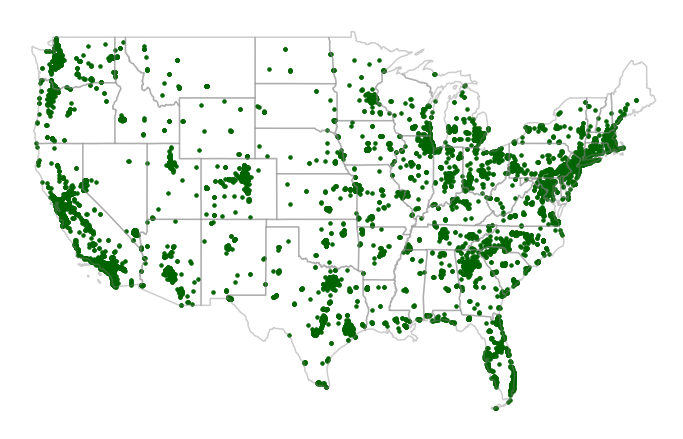

In [1461]:
fig,ax = plt.subplots(figsize=(12, 15))
geo_df.plot(ax=ax, color='darkgreen', markersize=12, marker='o')
geo_usa.boundary.plot(ax=ax, alpha=0.4, color='grey')
#geo_usa.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1)

minx, miny, maxx, maxy = geo_usa.total_bounds
ax.set_xlim(-127, -65)
ax.set_ylim(23, 51)

#plt.title(label='Starbucks Location in the USA',
#          fontsize=30,
#          color="darkgreen")

ax.axis("off")
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

In [1462]:
import folium
from folium import plugins

m = folium.Map([38,-100], tiles='Stamen Toner', zoom_start=5)

# convert to (n, 2) nd-array format for heatmap
stationArr = location[['Latitude', 'Longitude']].values

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=19))
m


## Census data

In [1463]:
#Merge county_df to acs_df
acs_df = acs_df.merge(county_df[['countyname','state','zip']], left_on='zip_code', right_on='zip', how='left')
acs_df.columns = acs_df.columns.str.lower()

acs_df = acs_df.drop(['zip'], axis=1)

In [1464]:
acs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 0 to 33119
Data columns (total 52 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zip_code              33120 non-null  int64  
 1   total_populatione     33120 non-null  int64  
 2   median_agee           32551 non-null  float64
 3   median_hh_incomee     30821 non-null  float64
 4   male_18_19e           33120 non-null  int64  
 5   male_20e              33120 non-null  int64  
 6   male_21e              33120 non-null  int64  
 7   male_22_24e           33120 non-null  int64  
 8   male_25_29e           33120 non-null  int64  
 9   male_30_34e           33120 non-null  int64  
 10  male_35_39e           33120 non-null  int64  
 11  male_40_44e           33120 non-null  int64  
 12  male_45_49e           33120 non-null  int64  
 13  male_50_54e           33120 non-null  int64  
 14  male_55_59e           33120 non-null  int64  
 15  male_60_61e        

In [1465]:
acs = acs_df.iloc[:, np.r_[0:4, 44:52]]

In [1466]:
acs['population_18_40'] = acs_df.iloc[:, np.r_[4:11, 23:30]].sum(axis=1)
acs['workers'] = acs_df.iloc[:, 42:44].sum(axis=1)

/var/folders/vz/68jlc85d78vcqcr5gx1r56l40000gn/T/ipykernel_28751/2562492653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['population_18_40'] = acs_df.iloc[:, np.r_[4:11, 23:30]].sum(axis=1)
/var/folders/vz/68jlc85d78vcqcr5gx1r56l40000gn/T/ipykernel_28751/2562492653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acs['workers'] = acs_df.iloc[:, 42:44].sum(axis=1)


In [1467]:
acs = acs.drop(['walk_to_worke'], axis=1)

In [1468]:
acs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 0 to 33119
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zip_code              33120 non-null  int64  
 1   total_populatione     33120 non-null  int64  
 2   median_agee           32551 non-null  float64
 3   median_hh_incomee     30821 non-null  float64
 4   median_home_valuee    30550 non-null  float64
 5   total_householdse     33120 non-null  int64  
 6   high_school_diplomae  33120 non-null  int64  
 7   bachelors_degreee     33120 non-null  int64  
 8   masters_degreee       33120 non-null  int64  
 9   countyname            33097 non-null  object 
 10  state                 33097 non-null  object 
 11  population_18_40      33120 non-null  int64  
 12  workers               33120 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 3.5+ MB


In [1469]:
new_cols = dict(zip(acs.columns[1:9], [str(x)[:-1] for x in acs.columns[1:9]]))
new_cols

{'total_populatione': 'total_population',
 'median_agee': 'median_age',
 'median_hh_incomee': 'median_hh_income',
 'median_home_valuee': 'median_home_value',
 'total_householdse': 'total_households',
 'high_school_diplomae': 'high_school_diploma',
 'bachelors_degreee': 'bachelors_degree',
 'masters_degreee': 'masters_degree'}

In [1470]:
acs.rename(columns= new_cols, inplace=True)
acs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 0 to 33119
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zip_code             33120 non-null  int64  
 1   total_population     33120 non-null  int64  
 2   median_age           32551 non-null  float64
 3   median_hh_income     30821 non-null  float64
 4   median_home_value    30550 non-null  float64
 5   total_households     33120 non-null  int64  
 6   high_school_diploma  33120 non-null  int64  
 7   bachelors_degree     33120 non-null  int64  
 8   masters_degree       33120 non-null  int64  
 9   countyname           33097 non-null  object 
 10  state                33097 non-null  object 
 11  population_18_40     33120 non-null  int64  
 12  workers              33120 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 3.5+ MB


In [1471]:
stores = starbuck_df.groupby(['Postcode']).size().reset_index(name='stores')

In [1472]:
#Merge Starbucks stores count to acs
df = acs.merge(stores, left_on='zip_code', right_on='Postcode', how='left')
df = df.drop(['Postcode'], axis=1)

df['stores'].fillna(0, inplace=True)

df['has_stores'] = np.where(
    df['stores'] == 0, 'No Starbucks', np.where(
    df['stores'] > 0, 'Has Starbucks', 'Others'))

df.head()

,zip_code,total_population,median_age,median_hh_income,median_home_value,total_households,high_school_diploma,bachelors_degree,masters_degree,countyname,state,population_18_40,workers,stores,has_stores
0,25245,600,54.8,57895.0,NaN,172,154,18,19,Jackson,WV,143,248,0.0,No Starbucks
1,25268,964,58.1,27200.0,69500.0,285,213,100,86,Calhoun,WV,164,263,0.0,No Starbucks
2,25286,1700,42.8,38313.0,129600.0,396,482,34,9,Roane,WV,269,478,0.0,No Starbucks
3,25303,6764,38.8,58820.0,140900.0,1745,1036,1143,571,Kanawha,WV,1990,3363,0.0,No Starbucks
4,25311,10964,40.0,40920.0,98700.0,2561,2290,1202,491,Kanawha,WV,3418,5366,0.0,No Starbucks


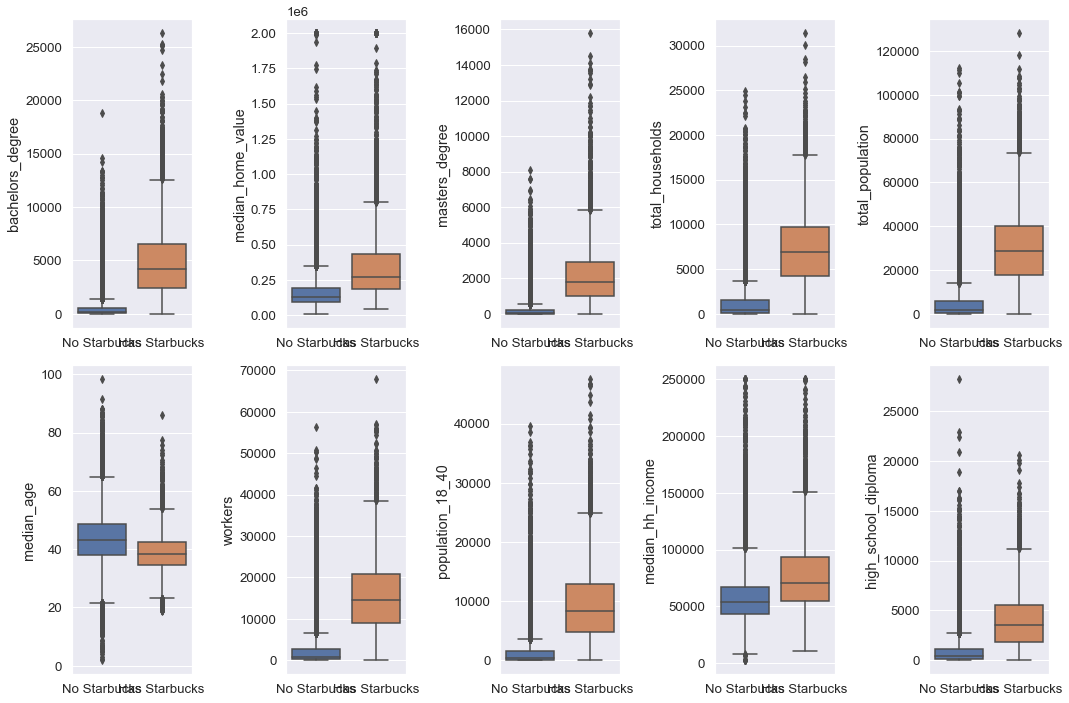

In [1473]:
numerical = list(set(df.columns) - set(['stores', 'zip_code', 'state', 'countyname', 'has_stores']))

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
for idx, feat in enumerate(numerical): 
    ax = axes[int(idx / 5), idx % 5] 
    sns.boxplot(x='has_stores', y=feat, data=df, ax=ax) 
    ax.set_xlabel('') 
    ax.set_ylabel(feat) 
fig.tight_layout();

In [1474]:
#plt.figure(figsize=(15,5))
#ax = sns.boxplot(x="total_populatione", y="has_stores", data=df)

In [1475]:
#plt.figure(figsize=(15,5))
#ax = sns.boxplot(x="median_hh_incomee", y="has_stores", data=df)

In [1476]:
#plt.figure(figsize=(15,5))
#ax = sns.boxplot(x="state", y="total_population", data=df)

In [1477]:
df_state = df.groupby('state', as_index=False).agg(total_population=('total_population','sum'),
                                                median_age=('median_age','median'),
                                                median_hh_income=('median_hh_income','median'),
                                                total_households=('total_households','sum'),
                                                high_school_diploma=('high_school_diploma','sum'),
                                                bachelors_degree=('bachelors_degree','sum'),
                                                masters_degree=('masters_degree','sum'),
                                                population_18_40=('population_18_40','sum'),
                                                workers=('workers','sum'),
                                                stores=('stores','sum'))
df_state['stores_per_cap'] = df_state.stores / df_state.total_population
df_state

,state,total_population,median_age,median_hh_income,total_households,high_school_diploma,bachelors_degree,masters_degree,population_18_40,workers,stores,stores_per_cap
0,AK,736502,34.15,53822.0,166244,108718,87977,37938,241966,393458,49.0,0.000067
1,AL,4876208,41.60,43243.0,1227485,841697,529178,230528,1397385,2190434,83.0,0.000017
2,AR,2999384,42.75,42486.0,765446,559805,297291,119010,863225,1351553,54.0,0.000018
3,AZ,7052789,39.40,51065.5,1679673,940749,869559,378514,2091842,3261320,481.0,0.000068
4,CA,39275176,39.40,68640.0,8958264,4812355,5602678,2294740,12432976,19232680,2800.0,0.000071
5,CO,5610419,40.30,62336.0,1369419,667803,981002,428252,1796711,3033743,478.0,0.000085
6,CT,3575074,44.65,88680.5,893438,588032,541380,315473,1000546,1852983,121.0,0.000034
7,DC,692617,33.70,93686.0,123683,70065,122360,104526,295629,398011,89.0,0.000128
8,DE,957248,40.70,62879.0,240038,187323,124632,64883,268649,468593,25.0,0.000026
9,FL,20897314,42.50,53966.0,4996043,3646850,2827667,1138760,5747617,9640609,680.0,0.000033


In [1478]:
geo_state = geo_usa.merge(df_state[['state','total_population', 'stores_per_cap']], left_on='STUSPS', right_on='state', how='left')
geo_state = geo_state.drop(['state'], axis=1)
geo_state = geo_state.sort_values('STUSPS')

geo_state

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,total_population,stores_per_cap
25,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48132 51.97530, 179.58286 ...",736502,0.000067
8,01,01779775,0400000US01,01,AL,Alabama,00,131174048583,4593327154,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",4876208,0.000017
9,05,00068085,0400000US05,05,AR,Arkansas,00,134768872727,2962859592,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",2999384,0.000018
50,04,01779777,0400000US04,04,AZ,Arizona,00,294198551143,1027337603,"POLYGON ((-114.79968 32.59362, -114.80939 32.6...",7052789,0.000068
12,06,01779778,0400000US06,06,CA,California,00,403503931312,20463871877,"MULTIPOLYGON (((-118.59397 33.46720, -118.4847...",39275176,0.000071
42,08,01779779,0400000US08,08,CO,Colorado,00,268422891711,1181621593,"POLYGON ((-109.05996 38.49999, -109.05151 39.1...",5610419,0.000085
34,09,01779780,0400000US09,09,CT,Connecticut,00,12542497068,1815617571,"POLYGON ((-73.69594 41.11526, -73.48271 41.212...",3575074,0.000034
36,11,01702382,0400000US11,11,DC,District of Columbia,00,158340391,18687198,"POLYGON ((-77.11976 38.93434, -77.04102 38.995...",692617,0.000128
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",957248,0.000026
24,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-81.81169 24.56874, -81.75127 ...",20897314,0.000033


/var/folders/vz/68jlc85d78vcqcr5gx1r56l40000gn/T/ipykernel_28751/3438392595.py:4: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  geo_state.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1)


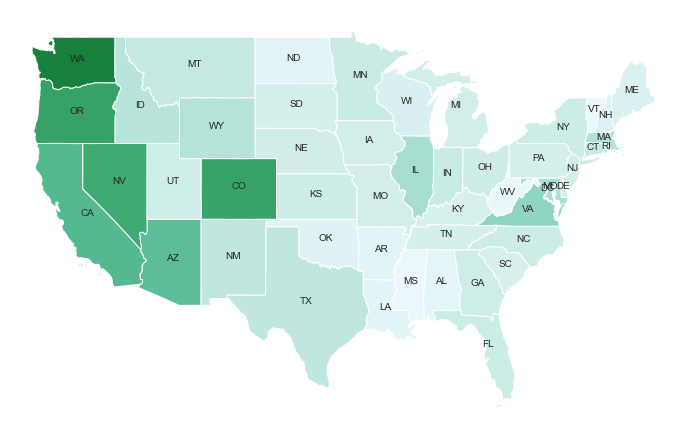

In [1479]:
fig,ax = plt.subplots(figsize=(12, 15))
#geo_df.plot(ax=ax, color='darkgreen', markersize=12, marker='o')
geo_state.plot(ax=ax, column='stores_per_cap', cmap=plt.cm.BuGn)
geo_state.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10),axis=1)

minx, miny, maxx, maxy = geo_state.total_bounds
ax.set_xlim(-127, -65)
ax.set_ylim(23, 51)

#plt.title(label='Starbucks Location in the USA',
#          fontsize=30,
#          color="darkgreen")

ax.axis("off")
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

In [1480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33120 entries, 0 to 33119
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   zip_code             33120 non-null  int64  
 1   total_population     33120 non-null  int64  
 2   median_age           32551 non-null  float64
 3   median_hh_income     30821 non-null  float64
 4   median_home_value    30550 non-null  float64
 5   total_households     33120 non-null  int64  
 6   high_school_diploma  33120 non-null  int64  
 7   bachelors_degree     33120 non-null  int64  
 8   masters_degree       33120 non-null  int64  
 9   countyname           33097 non-null  object 
 10  state                33097 non-null  object 
 11  population_18_40     33120 non-null  int64  
 12  workers              33120 non-null  int64  
 13  stores               33120 non-null  float64
 14  has_stores           33120 non-null  object 
dtypes: float64(4), int64(8), object(3)
m

In [1481]:
df_county = df.iloc[:, np.r_[0:9, 11:14]]
df_county

,zip_code,total_population,median_age,median_hh_income,median_home_value,total_households,high_school_diploma,bachelors_degree,masters_degree,population_18_40,workers,stores
0,25245,600,54.8,57895.0,NaN,172,154,18,19,143,248,0.0
1,25268,964,58.1,27200.0,69500.0,285,213,100,86,164,263,0.0
2,25286,1700,42.8,38313.0,129600.0,396,482,34,9,269,478,0.0
3,25303,6764,38.8,58820.0,140900.0,1745,1036,1143,571,1990,3363,0.0
4,25311,10964,40.0,40920.0,98700.0,2561,2290,1202,491,3418,5366,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33115,38704,2,NaN,NaN,NaN,0,2,0,0,0,0,0.0
33116,38731,246,36.7,53173.0,NaN,54,51,0,0,35,35,0.0
33117,38749,71,39.5,18750.0,NaN,29,28,0,0,29,16,0.0
33118,38781,198,54.3,10772.0,76100.0,41,65,7,6,47,30,0.0


In [1482]:
df_county = df.groupby(['countyname','state'], as_index=False).agg(total_population=('total_population','sum'),
                                                median_age=('median_age','median'),
                                                median_home_value=('median_home_value','median'),
                                                median_hh_income=('median_hh_income','median'),
                                                total_households=('total_households','sum'),
                                                high_school_diploma=('high_school_diploma','sum'),
                                                bachelors_degree=('bachelors_degree','sum'),
                                                masters_degree=('masters_degree','sum'),
                                                population_18_40=('population_18_40','sum'),
                                                workers=('workers','sum'),
                                                stores=('stores','sum'))
df_county = df_county.sort_values(['state','countyname'])

df_county['has_stores'] = np.where(
    df_county['stores'] == 0, 0, np.where(
    df_county['stores'] > 0, 1, -1))

df_county = df_county.dropna()

# Filter out PR
df_county = df_county[df_county.state != 'PR']

df_county

,countyname,state,total_population,median_age,median_home_value,median_hh_income,total_households,high_school_diploma,bachelors_degree,masters_degree,population_18_40,workers,stores,has_stores
37,Aleutians East,AK,3385,42.30,122200.0,67500.0,550,1069,208,80,1069,2419,0.0,0
38,Aleutians West,AK,5485,39.00,80450.0,63750.0,732,1384,551,81,1914,3706,0.0,0
63,Anchorage,AK,293311,35.25,320950.0,83632.0,68582,36524,42543,18242,101676,164470,28.0,1
209,Bethel,AK,18132,26.40,58700.0,38958.0,3415,3885,729,291,5878,7956,0.0,0
284,Bristol Bay,AK,953,45.50,179700.0,81875.0,211,208,134,21,241,564,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,Sweetwater,WY,43521,40.70,123700.0,70625.0,10794,7217,4136,1563,13371,22773,1.0,1
2840,Teton,WY,22403,46.90,873400.0,88566.5,5132,2217,6600,2317,7057,13610,3.0,1
2907,Uinta,WY,20488,40.30,174900.0,71960.0,5318,4404,1433,557,5425,9835,0.0,0
3014,Washakie,WY,8132,46.95,209450.0,53893.5,2202,1270,871,337,1763,3855,0.0,0


array([<AxesSubplot:ylabel='has_stores'>], dtype=object)

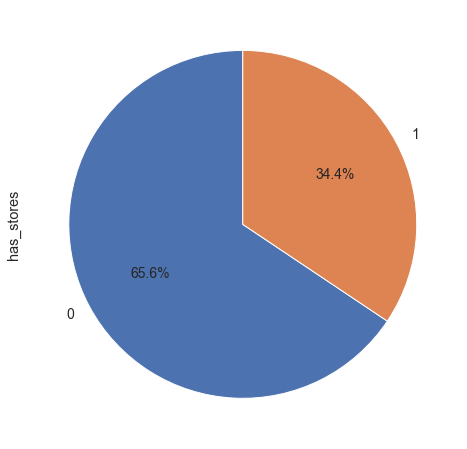

In [1483]:
# host_is_super_host - Pie chart

hasStores = df_county.has_stores.groupby(df_county.has_stores).count()

hasStores.plot(kind='pie', subplots=True,startangle=90,
figsize=(8,8), autopct='%1.1f%%', textprops={'fontsize': 14})

<AxesSubplot:>

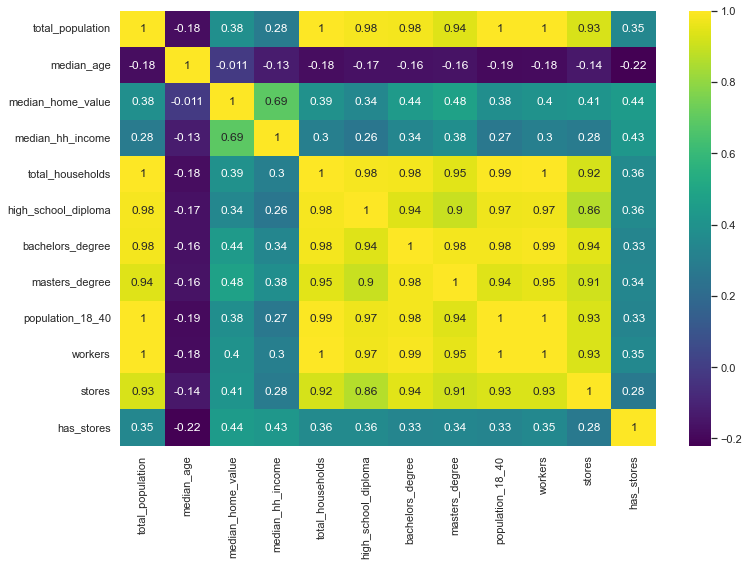

In [1484]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
sns.heatmap(df_county.corr(),annot=True,cmap='viridis')

In [1485]:
X = df_county.drop(['has_stores','countyname','state','total_households','high_school_diploma','bachelors_degree','masters_degree','population_18_40','workers','stores'],axis=1).values
#X = df_county.drop(['has_stores','countyname','state','total_households','high_school_diploma','bachelors_degree','population_18_40','workers','stores'],axis=1).values
#X = df_county.drop(['has_stores','countyname','state','stores'],axis=1).values
y = df_county['has_stores'].values

#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X)
X = scl_obj.transform(X)

In [1486]:
from sklearn.model_selection import StratifiedKFold

num_cv_iterations = 10 #Change to 10 fold for final optimization (longer compute time)
num_instances = len(y)
cv_object = StratifiedKFold(n_splits=num_cv_iterations, shuffle=True, random_state=27)

In [1487]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

scorer = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0)
}

In [1488]:
lr = LogisticRegression(penalty='l1', C=1.0, class_weight=None, solver='liblinear', random_state=0) # get object
#lr.fit(X,y)

cv_results = sklearn.model_selection.cross_validate(lr, X, y, cv=cv_object, scoring=scorer)
#print(cv_results)
print("Mean Accuracy = ",cv_results['test_accuracy'].mean())
print("Mean Sensitivity = ",cv_results['test_sensitivity'].mean())
print("Mean Specificity = ",cv_results['test_specificity'].mean())

Mean Accuracy =  0.8843102318341935
Mean Sensitivity =  0.7500259605399792
Mean Specificity =  0.9546980819322757


Validation Set Accuracy:  0.8830297219558965


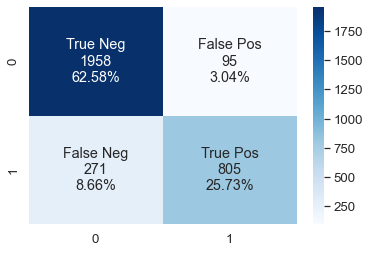

In [1489]:
from sklearn.metrics import confusion_matrix

lr_model_fit = lr.fit(X,y)
lr_validation_predictions = lr.predict(X)

#print(lr_validation_predictions)

from sklearn.metrics import accuracy_score
print("Validation Set Accuracy: ", accuracy_score(y, lr_validation_predictions))

import seaborn as sns

def plot_confusion(cf_matrix):
    sns.set(font_scale=1.2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
    cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')


lr_cm = confusion_matrix(y,lr_validation_predictions)
plot_confusion(lr_cm)

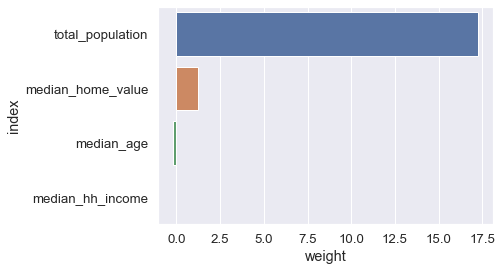

In [1490]:
weights = lr_model_fit.coef_.T # take transpose to make a column vector
variable_names = df_county.drop(['has_stores','countyname','state','total_households','high_school_diploma','bachelors_degree','masters_degree','population_18_40','workers','stores'],axis=1).columns 

coefficients = pd.DataFrame(weights,variable_names)
coefficients = coefficients.rename(columns={coefficients.columns[0]: 'weight'})
coefficients = coefficients.sort_values(by='weight', key=abs, ascending=False)
coefficients.reset_index(level=0, inplace=True)

ax = sns.barplot(y="index", x="weight", data=coefficients)

In [1491]:
future = df_county
future['predicted_stores'] = lr_validation_predictions
future = future[(future.has_stores == 0) & (future.predicted_stores == 1)]
future.sort_values('total_population', ascending=False).head(10)

,countyname,state,total_population,median_age,median_home_value,median_hh_income,total_households,high_school_diploma,bachelors_degree,masters_degree,population_18_40,workers,stores,has_stores,predicted_stores
576,Clayton,GA,233041,33.40,104950.0,53169.0,52073,43139,18447,6672,73619,110559,0.0,0,1
201,Berkeley,SC,162016,39.25,137000.0,54458.0,41604,26484,18830,7501,51111,81934,0.0,0,1
2437,Randolph,NC,148813,42.40,128300.0,48471.5,39587,27241,11532,3452,38699,70364,0.0,0,1
531,Citrus,FL,144796,57.00,132600.0,44789.0,39503,34825,13106,5826,25527,47115,0.0,0,1
2603,Schuylkill,PA,142515,44.80,94050.0,51923.0,38233,41980,11481,4239,35806,65167,0.0,0,1
743,Davidson,NC,139323,42.40,124800.0,48989.0,38440,26457,11277,3386,34769,64310,0.0,0,1
548,Clark,OH,133951,41.35,116500.0,54636.5,35358,29237,10492,5228,34998,63446,0.0,0,1
226,Blair,PA,125626,41.30,131500.0,52011.5,34090,37188,12681,4995,32388,59571,0.0,0,1
2209,Oswego,NY,120738,42.95,110600.0,57753.5,31101,24259,9141,5376,34312,60805,0.0,0,1
2723,St. Lawrence,NY,107008,43.35,94700.0,50700.0,25902,20957,8425,6508,32732,49413,0.0,0,1
